In [1]:
!pip install hdf5storage

     |████████████████████████████████| 53 kB 575 kB/s eta 0:00:01


In [5]:
#!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
#!bash download_data.sh


    3064


In [59]:
!python mat_to_numpy.py brain_tumor_dataset/

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


### Librairies ###

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import gc
from keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models , losses
from keras.models import load_model
from datetime import datetime
import time 
import tensorflow as tf

#init params
img_size_ori = 512
img_size_target = 128

Init Plugin
Init Graph Optimizer
Init Kernel


### Load Dataset ###

### PreprocessingData Class ###

In [6]:
class PreprocessingData():
    
    def __init__(self):
        
        self.integer_to_class = {'1': 'meningioma', '2': 'glioma', '3': 'pituitary tumor'}
        self.labels = np.load('../brain_tumor_dataset/labels.npy')
        self.images = np.clip( (np.load('../brain_tumor_dataset/images.npy')/12728),0,1)
        self.masks = np.load('../brain_tumor_dataset/masks.npy')*1
        
        self.X = []
        self.X_v = []
        self.Y = []
        self.Y_v = []
        #print(self.labels.shape)
        #print(self.images.shape)
        #print(self.masks.shape)
        #reshape arrays 
        #X = np.stack((X,)*3 , axis = -1)
        
    def getUpDownSampling(self):
        
        self.images = np.expand_dims(self.images,axis=-1)
        self.masks = np.expand_dims(self.masks,axis=-1)
        #self.images = np.stack((self.images,)*3 , axis = -1)
        #self.masks = np.stack((self.masks,)*3 , axis = -1)
        
        def downsample(img):
            if img_size_ori == img_size_target:
                return img
            return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
        def upsample(img):
            if img_size_ori == img_size_target:
                return img
            return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
        self.images = np.array([ downsample(image) for image in self.images ])
        self.masks = (np.array([ downsample(mask) for mask in self.masks ])>0)*1
        
        print(self.images.shape)
        print(self.masks.shape)  
        
        return self.images , self.masks
    
    #Split Data to Two parts Training set and Validation set 
    def splitData(self , size):
        
        self.X,self.X_v,self.Y,self.Y_v = train_test_split(self.images,self.masks,test_size=size,stratify=self.labels)
        gc.collect()
        return self.X,self.X_v,self.Y,self.Y_v
    
    def dataAugmentation(self , batch_s):
        
        self.X = np.append( self.X, [ np.fliplr(x) for x in self.X], axis=0 )
        self.Y = np.append( self.Y, [ np.fliplr(y) for y in self.Y], axis=0 )
        print(self.X.shape , self.Y.shape)
        #Data generation
        train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                           zoom_range=[.9,1.1],
                                           fill_mode='nearest')
        val_datagen = ImageDataGenerator()
        
        train_generator = train_datagen.flow(self.X, self.Y, batch_size=batch_s)
        val_generator = val_datagen.flow(self.X_v, self.Y_v, batch_size=batch_s)
        
        return train_generator , val_generator 
        
        
        
        
        

### Call instance object from PreprocessingData Class ###

In [20]:
#create object instance from preprocessing data class 
processingObject = PreprocessingData()

In [21]:
#get images , masks arrays 
imgs , msks = processingObject.getUpDownSampling()

(3064, 128, 128, 1)
(3064, 128, 128, 1)


#### Plot Labels ####

<BarContainer object of 3 artists>

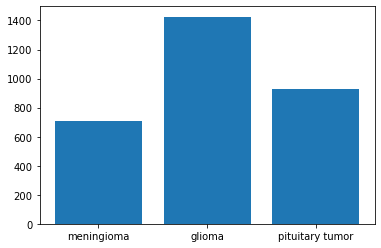

In [22]:
classes, counts = np.unique(processingObject.labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(processingObject.integer_to_class.values()))
#print(counts)
#print(classes)

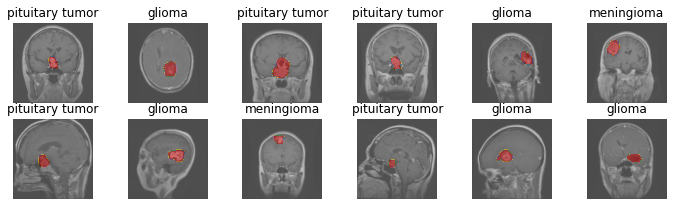

In [23]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(imgs.shape[0], size=12), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(imgs[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(msks[idx])-msks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(processingObject.integer_to_class[str(processingObject.labels[idx])])
    plt.axis('off')

#### Train Image and its mask which is to be predicted ####

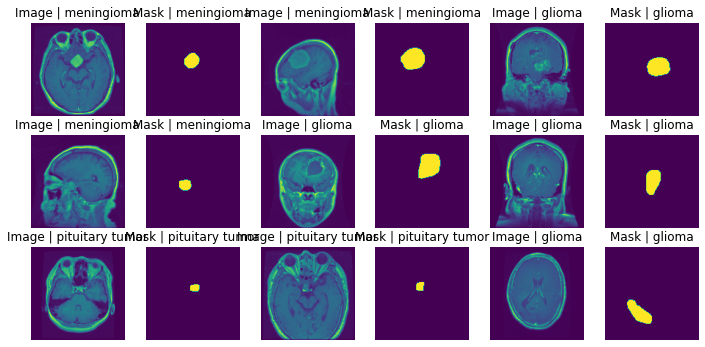

In [24]:
plt.figure(figsize=(12, 12))
i=1
for idx in np.random.randint( imgs.shape[0], size=9):
  plt.subplot(6,6,i);i+=1
  plt.imshow( np.squeeze(imgs[idx],axis=-1))
  plt.title("Image | "+processingObject.integer_to_class[str(processingObject.labels[idx])])
  plt.axis('off')
  plt.subplot(6,6,i);i+=1
  plt.imshow( np.squeeze(msks[idx],axis=-1)) 
  plt.title("Mask | "+processingObject.integer_to_class[str(processingObject.labels[idx])])
  plt.axis('off')

### Split data ###

In [32]:
X,X_v,Y,Y_v = processingObject.splitData(0.2) #20% for validation set 
X.shape,X_v.shape,Y.shape,Y_v.shape

((2451, 128, 128, 1),
 (613, 128, 128, 1),
 (2451, 128, 128, 1),
 (613, 128, 128, 1))

### Data Augmentation ###

In [33]:
train_generator , val_generator  = processingObject.dataAugmentation(32)

(4902, 128, 128, 1) (4902, 128, 128, 1)


## Build Model Class ##

In [34]:

#Build Model Class 
class BuildModel():
    
    def __init__(self):
        self.model = None
        self.model_history = None
        
        
    def getModel(self, model_type , basedModel = None , output_classes = 1 , weights = None , freeze_backbone = False ,freeze_batch_norm = False ):
        
        if model_type == "AttentionUnet":
            
            #get Attention Unet Model
            self.model = models.att_unet_2d((128, 128, 1), 
                                                filter_num=[16,32,64, 128, 256],
                                                n_labels=output_classes,
                                                stack_num_down=2, 
                                                stack_num_up=2, 
                                                activation='ReLU', 
                                                atten_activation='ReLU', 
                                                attention='add', 
                                                output_activation='Sigmoid', 
                                                batch_norm=True, 
                                                pool=True, 
                                                unpool=True, 
                                                backbone=basedModel, 
                                                weights=weights, 
                                                freeze_backbone=freeze_backbone, 
                                                freeze_batch_norm=freeze_batch_norm, 
                                                name='BrainTumorAttUnet')
        elif model_type == "Unet++":
            
            self.model = models.unet_plus_2d((128, 128, 1), 
                                                filter_num=[16,32,64, 128, 256],
                                                n_labels=output_classes,
                                                stack_num_down=2, 
                                                stack_num_up=2, 
                                                activation='ReLU', 
                                                output_activation='Sigmoid', 
                                                batch_norm=True, 
                                                pool=True, 
                                                unpool=True, 
                                                backbone=basedModel, 
                                                weights=weights, 
                                                freeze_backbone=freeze_backbone, 
                                                freeze_batch_norm=freeze_batch_norm, 
                                                name='BrainTumorUnetPlusPlus')
        elif model_type == "Unet":
            
            
            self.model = models.unet_2d((128, 128, 1), 
                                                filter_num=[16,32,64, 128, 256],
                                                n_labels=output_classes,
                                                stack_num_down=2, 
                                                stack_num_up=2, 
                                                activation='ReLU', 
                                                output_activation='Sigmoid', 
                                                batch_norm=True, 
                                                pool=True, 
                                                unpool=True, 
                                                backbone=None, weights=None,
                                                freeze_backbone=False, freeze_batch_norm=False, 
                                                name='BrainTumorUnet')



          
            
            
  
        return self.model

    def trainingModel(self ,xtrain , ytrain , model_type , basedModel = None , output_classes = 1 , epochs = 50 ,  weights = None , freeze_backbone = False ,freeze_batch_norm = False):
        
        #get Model 
        self.getModel(model_type , basedModel, output_classes , weights , freeze_backbone , freeze_batch_norm )
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', losses.dice_coef])
        print(self.model.summary())
        #Build Model Fitting
        start = datetime.now() 
        callbacks= [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]
        self.model_history = self.model.fit(xtrain, ytrain, 
                            verbose=1,
                            batch_size = 32,
                            validation_split=0.1, 
                            shuffle=False,
                            epochs=epochs, callbacks=callbacks)

        stop = datetime.now()
        #Execution time of the model 
        execution_time_att_Unet = stop-start
        print("Attention UNet execution time is: ", execution_time_att_Unet)
        
        t = time.time()
        
        file_model_path = "Best_Model_Save"
        if model_type == "AttentionUnet":
            file_model_path = '../Saved/Brain_Tumor_Att_UNet_50epochs.h5'.format(int(t))
            dataFrameScores = pd.DataFrame(self.model_history.history)
            with open('../Saved/brain_tumor_att_unet_history.csv', mode='w') as f:
                dataFrameScores.to_csv(f)
            
        elif model_type == "Unet++":
            file_model_path = '../Saved/Brain_Tumor_UNet++_50epochs.h5'.format(int(t))
            dataFrameScores = pd.DataFrame(self.model_history.history)
            with open('../Saved/brain_tumor_unetplusplus_history.csv', mode='w') as f:
                 dataFrameScores.to_csv(f)
            
        elif model_type == "Unet":
            file_model_path = '../Saved/Brain_Tumor_UNet_50epochs.h5'.format(int(t))
            dataFrameScores = pd.DataFrame(self.model_history.history)
            with open('../Saved/brain_tumor_unet_history.csv', mode='w') as f:
                 dataFrameScores.to_csv(f)
            
            
        print("Save Model Path : " , file_model_path)
        self.model.save(file_model_path)
 

### Call Build Model Class ###

In [35]:
buildModel = BuildModel()

In [36]:
buildModel.trainingModel(
                        xtrain = X,
                        ytrain = Y,
                        model_type = 'AttentionUnet',
                        output_classes = 1 , 
                        epochs = 50 
                        
                        )

Model: "BrainTumorAttUnet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
BrainTumorAttUnet_down0_0 (Conv (None, 128, 128, 16) 144         input_4[0][0]                    
__________________________________________________________________________________________________
BrainTumorAttUnet_down0_0_bn (B (None, 128, 128, 16) 64          BrainTumorAttUnet_down0_0[0][0]  
__________________________________________________________________________________________________
BrainTumorAttUnet_down0_0_activ (None, 128, 128, 16) 0           BrainTumorAttUnet_down0_0_bn[0][0
____________________________________________________________________________

2022-09-17 23:11:31.693251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9517 - dice_coef: 0.0484

2022-09-17 23:12:00.527957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 31s 410ms/step - loss: 0.3123 - accuracy: 0.9517 - dice_coef: 0.0484 - val_loss: 0.8209 - val_accuracy: 0.2809 - val_dice_coef: 0.0521
Epoch 2/50
69/69 [==============================] - 27s 390ms/step - loss: 0.1755 - accuracy: 0.9743 - dice_coef: 0.0641 - val_loss: 0.3211 - val_accuracy: 0.9765 - val_dice_coef: 0.0511
Epoch 3/50
69/69 [==============================] - 27s 385ms/step - loss: 0.1315 - accuracy: 0.9745 - dice_coef: 0.1000 - val_loss: 0.1850 - val_accuracy: 0.9765 - val_dice_coef: 0.0944
Epoch 4/50
69/69 [==============================] - 27s 391ms/step - loss: 0.1012 - accuracy: 0.9781 - dice_coef: 0.1700 - val_loss: 0.1223 - val_accuracy: 0.9760 - val_dice_coef: 0.0472
Epoch 5/50
69/69 [==============================] - 28s 396ms/step - loss: 0.0809 - accuracy: 0.9808 - dice_coef: 0.2570 - val_loss: 0.1199 - val_accuracy: 0.9723 - val_dice_coef: 0.0475
Epoch 6/50
69/69 [==============================] - 25s 368ms/step - loss: 0

/Users/zahr-eddine/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Performance Accuracy, Loss , Dice ##

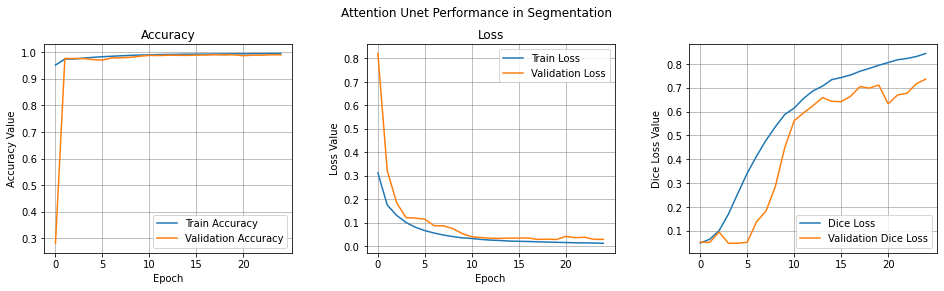

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Attention Unet Performance in Segmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
history = buildModel.model_history
epoch_list = history.epoch

#for Accuracy
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

#for Loss
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)


#for Dice Loss
ax3.plot(epoch_list, history.history['dice_coef'], label='Dice Loss')
ax3.plot(epoch_list, history.history['val_dice_coef'], label='Validation Dice Loss')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Dice Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)



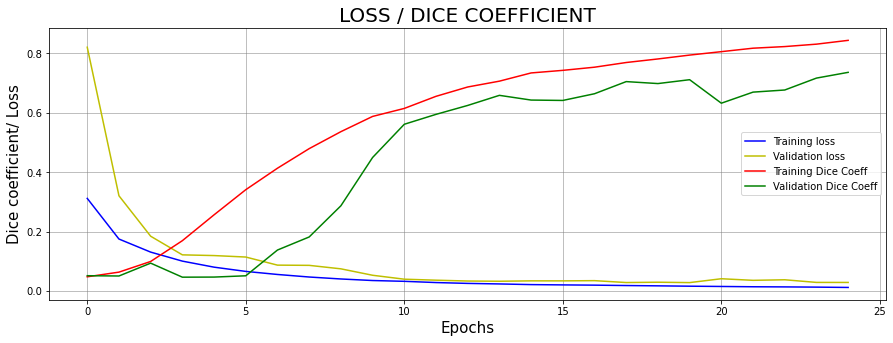

In [48]:
import pandas as pd
df = pd.read_csv("../saved/brain_tumor_att_unet_history.csv" , sep = ",")
plt.figure(figsize=(15, 5))
plt.plot(df.loss , 'b', label='Training loss')
plt.plot(df.val_loss, 'y', label='Validation loss')
plt.plot(df.dice_coef, 'r', label='Training Dice Coeff')
plt.plot(df.val_dice_coef , 'g', label='Validation Dice Coeff')
plt.title('LOSS / DICE COEFFICIENT', size=20)
plt.xlabel('Epochs', size=15)
plt.ylabel('Dice coefficient/ Loss', size=15)
plt.legend(loc="best");plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

## Load Model ##

In [49]:

unet_model = load_model('../Saved/Brain_Tumor_Att_UNet_50epochs.h5', compile=False) #or compile = False
unet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', losses.dice_coef])


## Predict Model ##

In [50]:
import random


idx = random.randint(0, len(X))
preds_train = unet_model.predict(X[:int(X.shape[0]*0.9)], verbose=1)
preds_val = unet_model.predict(X[int(X.shape[0]*0.9):], verbose=1)
preds_test = unet_model.predict(X_v, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


2022-09-18 00:03:01.736223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2s 86ms/step


In [53]:

ids = [752, 454, 887,100]
temp = np.ones_like( Y_v[0] )
THRESHOLD = 0.5
predicted_mask = (unet_model.predict(X_v)>THRESHOLD)*1

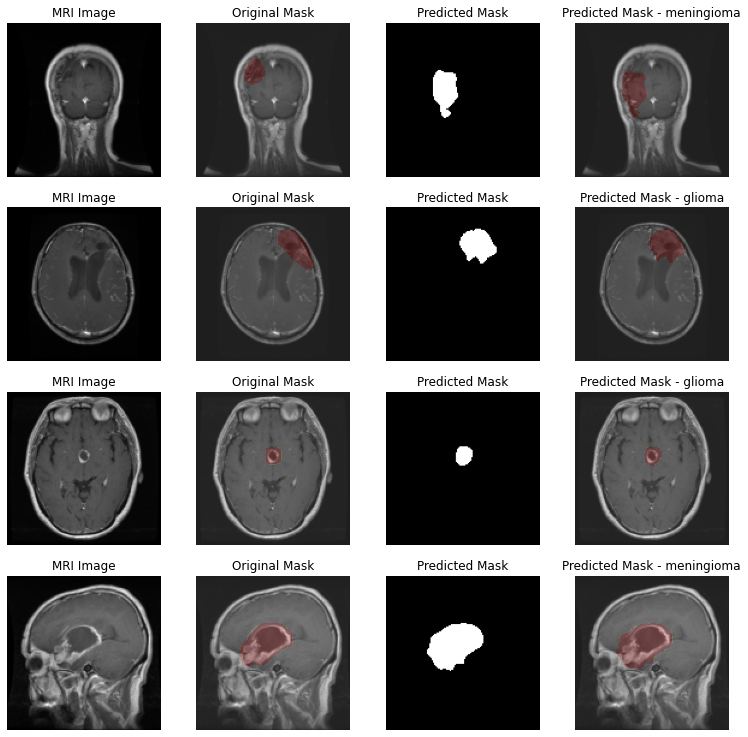

In [58]:

plt.figure(figsize=(13, 13))
j=1
total=4
for i in range(0,len(ids)):
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[i],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(predicted_mask[i],axis=-1), cmap='gray' )
    plt.title("Predicted Mask");plt.axis('off')
    
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[i],axis=-1),  alpha=0.2 ,  cmap='Set1')
    plt.title("Predicted Mask - "+processingObject.integer_to_class[str(processingObject.labels[i])]);plt.axis('off')
    

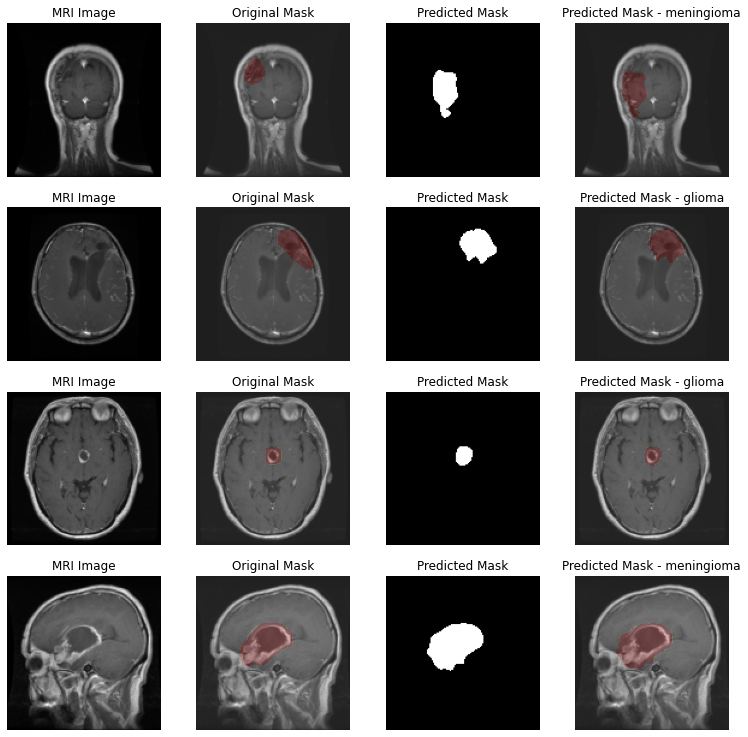

In [59]:

plt.figure(figsize=(13, 13))
j=1
total=4
for i in range(0,len(ids)):
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[i],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(predicted_mask[i],axis=-1), cmap='gray' )
    plt.title("Predicted Mask");plt.axis('off')
    
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[i],axis=-1),  alpha=0.2 ,  cmap='Set1')
    plt.title("Predicted Mask - "+processingObject.integer_to_class[str(processingObject.labels[i])]);plt.axis('off')
    